# MNIST Image Classification with TensorFlow

This notebook demonstrates how to implement a simple linear image model on [MNIST](http://yann.lecun.com/exdb/mnist/) using the [tf.keras API](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras). It builds the foundation for this <a href="mnist_models.ipynb">companion notebook</a>, which explores tackling the same problem with other types of models such as DNN and CNN.

## Learning Objectives
1. Know how to read and display image data
2. Know how to find incorrect predictions to analyze the model
3. Visually see how computers see images

This notebook uses TF2.0
Please check your tensorflow version using the cell below. If it is not 2.0, please run the pip line below and restart the kernel.

In [1]:
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Dense, Flatten, Softmax

print(tf.__version__)

2.0.0-beta1


In [2]:
!pip freeze | grep tensorflow==2 || pip install tensorflow==2.0.0

tensorflow==2.0.0b1


## Exploring the data

The MNIST dataset is already included in tensorflow through the keras datasets module. Let's load it and get a sense of the data.

In [3]:
mnist = tf.keras.datasets.mnist.load_data()
(x_train, y_train), (x_test, y_test) = mnist

In [4]:
HEIGHT, WIDTH = x_train[0].shape
NCLASSES = tf.size(tf.unique(y_train).y)
print("Image height x width is", HEIGHT, "x", WIDTH)
tf.print("There are", NCLASSES, "classes")

Image height x width is 28 x 28
There are 10 classes


Each image is 28 x 28 pixels and represents a digit from 0 to 9. These images are black and white, so each pixel is a value from 0 (white) to 255 (black). Raw numbers can be hard to interpret sometimes, so we can plot the values to see the handwritten digit as an image.

The label for image number 12 is 9


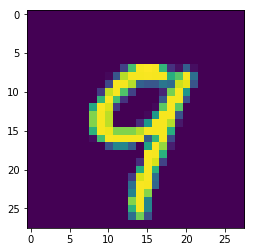

In [5]:
IMGNO = 12
# Uncomment to see raw numerical values.
# print(x_test[IMGNO])
plt.imshow(x_test[IMGNO].reshape(HEIGHT, WIDTH));
print("The label for image number", IMGNO, "is", y_test[IMGNO])

## Define the model
Let's start with a very simple linear classifier. This was the first method to be tried on MNIST in 1998, and scored an 88% accuracy. Quite ground breaking at the time!

We can build our linear classifer using the [tf.keras API](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras), so we don't have to define or initialize our weights and biases. This happens automatically for us in the background. We can also add a softmax layer to transform the logits into probabilities. Finally, we can compile the model using categorical crossentropy in order to strongly penalize high probability predictions that were incorrect.

When building more complex models such as DNNs and CNNs our code will be more readable by using the [tf.keras API](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras). Let's get one working so we can test it and use it as a benchmark.

In [6]:
def linear_model():
    model = Sequential([
        Flatten(),
        Dense(NCLASSES),
        Softmax()
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

## Write Input Functions

As usual, we need to specify input functions for training and evaluating. We'll scale each pixel value so it's a decimal value between 0 and 1 as a way of normalizing the data.

**TODO 1**: Define the scale function below

In [7]:
BUFFER_SIZE = 5000
BATCH_SIZE = 100


def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    return image, label


def load_dataset(training=True):
    """Loads MNIST dataset into a tf.data.Dataset"""
    (x_train, y_train), (x_test, y_test) = mnist
    x = x_train if training else x_test
    y = y_train if training else y_test
    # One-hot encode the classes
    y = tf.keras.utils.to_categorical(y, NCLASSES)
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(scale).batch(BATCH_SIZE)
    if training:
        dataset = dataset.shuffle(BUFFER_SIZE).repeat()
    return dataset

In [8]:
def create_shape_test(training):
    dataset = load_dataset(training=training)
    data_iter = dataset.__iter__()
    (images, labels) = data_iter.get_next()
    expected_image_shape = (BATCH_SIZE, HEIGHT, WIDTH)
    expected_label_ndim = 2
    assert(images.shape == expected_image_shape)
    assert(labels.numpy().ndim == expected_label_ndim)
    test_name = 'training' if training else 'eval'
    print("Test for", test_name, "passed!")


create_shape_test(True)
create_shape_test(False)

Test for training passed!
Test for eval passed!


Time to train the model! The original MNIST linear classifier had an error rate of 12%. Let's use that to sanity check that our model is learning.

In [9]:
NUM_EPOCHS = 10
STEPS_PER_EPOCH = 100

model = linear_model()
train_data = load_dataset()
validation_data = load_dataset(training=False)

OUTDIR = "mnist_linear/"
checkpoint_callback = ModelCheckpoint(
    OUTDIR, save_weights_only=True, verbose=1)
tensorboard_callback = TensorBoard(log_dir=OUTDIR)

history = model.fit(
    train_data, 
    validation_data=validation_data,
    epochs=NUM_EPOCHS, 
    steps_per_epoch=STEPS_PER_EPOCH,
    verbose=2,
    callbacks=[checkpoint_callback, tensorboard_callback]
)

Epoch 1/10


W1021 17:02:56.895096 139661572232960 deprecation.py:323] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 00001: saving model to mnist_linear/
100/100 - 17s - loss: 1.2784 - accuracy: 0.5258 - val_loss: 0.7747 - val_accuracy: 0.8355
Epoch 2/10

Epoch 00002: saving model to mnist_linear/
100/100 - 2s - loss: 0.6736 - accuracy: 0.8337 - val_loss: 0.5517 - val_accuracy: 0.8703
Epoch 3/10

Epoch 00003: saving model to mnist_linear/
100/100 - 2s - loss: 0.5277 - accuracy: 0.8672 - val_loss: 0.4671 - val_accuracy: 0.8843
Epoch 4/10

Epoch 00004: saving model to mnist_linear/
100/100 - 2s - loss: 0.4720 - accuracy: 0.8871 - val_loss: 0.4169 - val_accuracy: 0.8940
Epoch 5/10

Epoch 00005: saving model to mnist_linear/
100/100 - 1s - loss: 0.4129 - accuracy: 0.8829 - val_loss: 0.3881 - val_accuracy: 0.8990
Epoch 6/10

Epoch 00006: saving model to mnist_linear/
100/100 - 2s - loss: 0.3933 - accuracy: 0.8919 - val_loss: 0.3668 - val_accuracy: 0.9029
Epoch 7/10

Epoch 00007: saving model to mnist_linear/
100/100 - 2s - loss: 0.3696 - accuracy: 0.8981 - val_loss: 0.3525 - val_accuracy: 0.9065
Ep

In [10]:
BENCHMARK_ERROR = .12
BENCHMARK_ACCURACY = 1 - BENCHMARK_ERROR

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
    
assert(accuracy[-1] > BENCHMARK_ACCURACY)
assert(val_accuracy[-1] > BENCHMARK_ACCURACY)
print("Test to beat benchmark accuracy passed!")
        
assert(accuracy[0] < accuracy[1])
assert(accuracy[1] < accuracy[-1])
assert(val_accuracy[0] < val_accuracy[1])
assert(val_accuracy[1] < val_accuracy[-1])
print("Test model accuracy is improving passed!")
    
assert(loss[0] > loss[1])
assert(loss[1] > loss[-1])
assert(val_loss[0] > val_loss[1])
assert(val_loss[1] > val_loss[-1])
print("Test loss is decreasing passed!")

Test to beat benchmark accuracy passed!
Test model accuracy is improving passed!
Test loss is decreasing passed!


## Evaluating Predictions

Let's check Tensorboard to visually see how the model's accuracy and loss change over time. If running on a Deep Learning VM, open the folder `courses/machine_learning/images/mnist_linear`. Then, go to File > New Launcher. Click on Tensorboard under "Other".

If runnining locally, the following command can be run in a terminal:

`tensorboard --logdir=<path-to-data-directory>`

Were you able to get an accuracy of over 90%? Not bad for a linear estimator! Let's make some predictions and see if we can find where the model has trouble. Change the range of values below to find incorrect predictions, and plot the corresponding images. What would you have guessed for these images?

**TODO 2**: Change the range below to find an incorrect prediction

In [11]:
image_numbers = range(0, 10, 1)  # Change me, please.

def load_prediction_dataset():
    dataset = (x_test[image_numbers], y_test[image_numbers])
    dataset = tf.data.Dataset.from_tensor_slices(dataset)
    dataset = dataset.map(scale).batch(len(image_numbers))
    return dataset

predicted_results = model.predict(load_prediction_dataset())
for index, prediction in enumerate(predicted_results):
    predicted_value = np.argmax(prediction)
    actual_value = y_test[image_numbers[index]]
    if actual_value != predicted_value:
        print("image number: " + str(image_numbers[index]))
        print("the prediction was " + str(predicted_value))
        print("the actual label is " + str(actual_value))
        print("")

image number: 8
the prediction was 6
the actual label is 5



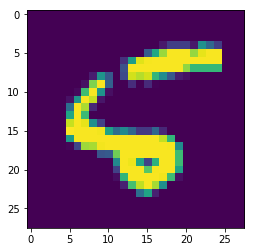

In [12]:
bad_image_number = 8
plt.imshow(x_test[bad_image_number].reshape(HEIGHT, WIDTH));

It's understandable why the poor computer would have some trouble. Some of these images are difficult for even humans to read. In fact, we can see what the computer thinks each digit looks like.

Each of the 10 neurons in the dense layer of our model has 785 weights feeding into it. That's 1 weight for every pixel in the image + 1 for a bias term. These weights are flattened feeding into the model, but we can reshape them back into the original image dimensions to see what the computer sees.

**TODO 3**: Reshape the layer weights to be the shape of an input image and plot.

In [ ]:
DIGIT=0 # Change me to be an integer from 0 to 9.
LAYER=1 # Layer 0 flattens image, so no weights
WEIGHT_TYPE=0 # 0 for variable weights, 1 for biases

dense_layer_weights = model.layers[LAYER].get_weights()
digit_weights = dense_layer_weights[WEIGHT_TYPE][:,DIGIT]
plt.imshow(digit_weights.reshape((HEIGHT, WIDTH)))

Did you recognize the digit the computer was trying to learn? Pretty trippy, isn't it! Even with a simple "brain", the computer can form a idea of what a digit should be. The human brain, however, uses [layers and layers of calculations for image recognition](https://www.salk.edu/news-release/brain-recognizes-eye-sees/). Ready for the next challenge? <a href="mnist_models.ipynb">Click here</a> to super charge our models with human-like vision.

## Bonus Exercise

Want to push your understanding further? Instead of using Keras'es built in layers, try repeating the above exercise with your own [custom layers](https://www.tensorflow.org/tutorials/eager/custom_layers).

Copyright 2019 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.